In [1]:
%matplotlib inline
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
from multiprocessing import Pool
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as ss
from akapriori import apriori
import armine
import networkx as nx
import hashlib
#import mpld3
#mpld3.enable_notebook()
#fig_size=[15,7]
#plt.rcParams["figure.figsize"]= fig_size

## Read Data (products, departments, aisles,orders and products per order)

In [2]:
orders_all = pd.read_csv("orders.csv",index_col=None,header=0)
orders_prod_p=pd.read_csv("order_products__prior.csv",index_col=None,header=0)
orders_prod_t=pd.read_csv("order_products__train.csv",index_col=None,header=0)
products=pd.read_csv("products.csv",index_col=None,header=0)
dept=pd.read_csv("departments.csv",index_col=None,header=0)
aisles=pd.read_csv("aisles.csv",index_col=None,header=0)
orders_prod_p=orders_prod_p.append(orders_prod_t)


## Explore Data

### Number of products purchased

In [3]:
len(orders_prod_p)

33819106

### Number of Orders

In [4]:
len(orders_all)

3421083

### Orders data

In [5]:
orders_all.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


### Products per order

In [7]:
orders_prod_p.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


### Number of unique customers

In [11]:
## Number of customers

len(orders_all.user_id.drop_duplicates())

206209

### Products details

In [8]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


### Total number of products

In [9]:
len(products)

49688

### Departments

In [251]:
dept.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


### Aisles

In [12]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


## Join all data in to one dataframe

In [14]:
orders_prod_norm=orders_prod_p.merge(orders_all,on="order_id")

In [15]:
orders_prod_norm=orders_prod_norm.merge(products,on="product_id")

In [16]:
orders_prod_norm=orders_prod_norm.merge(aisles,on="aisle_id")

In [17]:
orders_prod_norm=orders_prod_norm.merge(dept,on="department_id")

In [18]:
orders_prod_norm.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,26,33120,5,0,153404,prior,2,0,16,7.0,Organic Egg Whites,86,16,eggs,dairy eggs
2,120,33120,13,0,23750,prior,11,6,8,10.0,Organic Egg Whites,86,16,eggs,dairy eggs
3,327,33120,5,1,58707,prior,21,6,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
4,390,33120,28,1,166654,prior,48,0,12,9.0,Organic Egg Whites,86,16,eggs,dairy eggs


### Group orders by products and get the how many times each product was ordered (Banana is the top ordered product)

In [22]:
g=orders_prod_norm.product_id.value_counts()
g=pd.DataFrame(g)
g.reset_index(inplace=True)
g.columns = ["product_id","count"]
g_products=g.merge(products,on="product_id")
g_products.head()

,product_id,count,product_name,aisle_id,department_id
0,24852,491291,Banana,24,4
1,13176,394930,Bag of Organic Bananas,24,4
2,21137,275577,Organic Strawberries,24,4
3,21903,251705,Organic Baby Spinach,123,4
4,47209,220877,Organic Hass Avocado,24,4


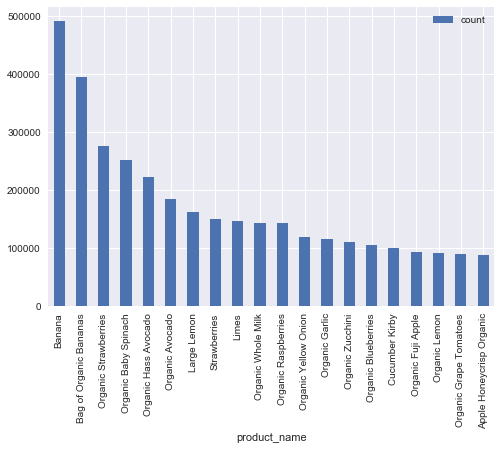

In [267]:
my_dpi=96
plt.figure(figsize=(50, 40), dpi=my_dpi)
plt.gcf().subplots_adjust(bottom=0.15)
g_products.head(20).plot(kind="bar",x="product_name",y="count")
plt.savefig("chart1.png",my_dpi=1000,bbox_inches="tight" )

### Products orders Count Distribution 

(0.99999999999150102, 679.67033231733865)


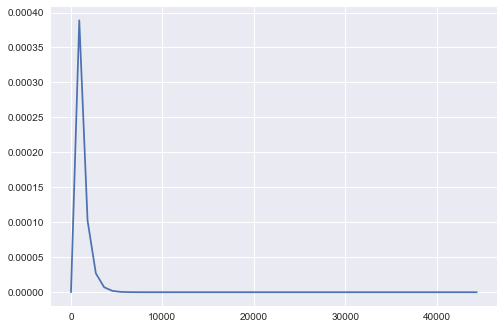

In [26]:
#g_products[g_products["count"]>10].hist("count",bins=50)
P=ss.expon.fit(g_products["count"])
print(P)
rX=np.linspace(0,44380)
rP =ss.expon.pdf(rX,*P)
plt.plot(rX,rP)

### Group by department (number of orders per department)

In [252]:
g=orders_prod_norm.department_id.value_counts()
g=pd.DataFrame(g)
g.reset_index(inplace=True)
g.columns = ["department_id","count"]
g_dept=g.merge(dept,on="department_id")
g_dept.head(5)

,department_id,count,department
0,4,9888378,produce
1,16,5631067,dairy eggs
2,19,3006412,snacks
3,7,2804175,beverages
4,1,2336858,frozen


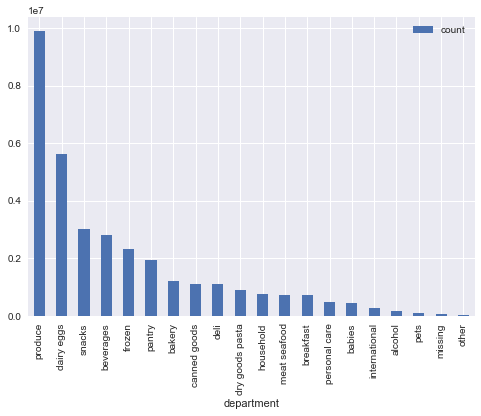

In [268]:
g_dept.head(20).plot(kind="bar",x="department",y="count")
plt.savefig("chart2.png",my_dpi=1000,bbox_inches="tight" )

### Dept orders count distribution

(35931.98839152544, 1574994.1129069394)


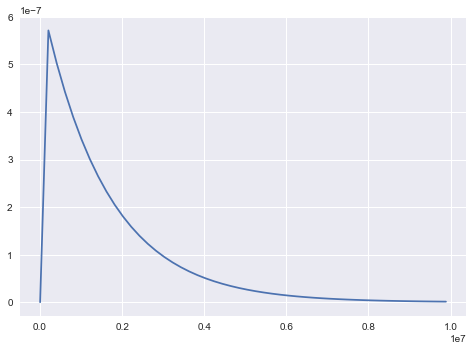

In [35]:

P=ss.expon.fit(g_dept["count"])
print(P)
rX=np.linspace(0,g_dept["count"].max())
rP =ss.expon.pdf(rX,*P)
plt.plot(rX,rP)

### Group by aisles (number of orders per aisle)

In [269]:
g=orders_prod_norm.aisle_id.value_counts()
g=pd.DataFrame(g)
g.reset_index(inplace=True)
g.columns = ["aisle_id","count"]
g_aisles=g.merge(aisles,on="aisle_id")
g_aisles.head()

,aisle_id,count,aisle
0,24,3792661,fresh fruits
1,83,3568630,fresh vegetables
2,123,1843806,packaged vegetables fruits
3,120,1507583,yogurt
4,21,1021462,packaged cheese


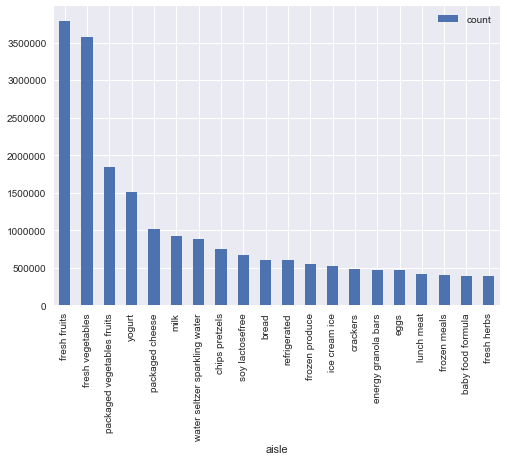

In [40]:
g_aisles.head(20).plot(kind="bar",x="aisle",y="count")

### Aisles orders count distribution

(5146.9999999997608, 247234.37862478918)


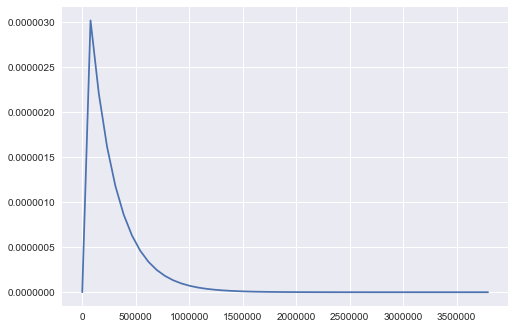

In [42]:

P=ss.expon.fit(g_aisles["count"])
print(P)
rX=np.linspace(0,g_aisles["count"].max())
rP =ss.expon.pdf(rX,*P)
plt.plot(rX,rP)

# Restructure Data

## For Market Basket Analysis

In [271]:
orders_prod_norm.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department,product_id_str
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs,33120
1,26,33120,5,0,153404,prior,2,0,16,7.0,Organic Egg Whites,86,16,eggs,dairy eggs,33120
2,120,33120,13,0,23750,prior,11,6,8,10.0,Organic Egg Whites,86,16,eggs,dairy eggs,33120
3,327,33120,5,1,58707,prior,21,6,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs,33120
4,390,33120,28,1,166654,prior,48,0,12,9.0,Organic Egg Whites,86,16,eggs,dairy eggs,33120


### Create column of lists contains all the products bought per order

In [47]:
orders_prod_norm["product_id_str"]=orders_prod_norm["product_id"].astype(str)

In [48]:

g=orders_prod_norm.groupby("order_id")["product_name"]

In [49]:
g1=g.apply(lambda x: ','.join(x.str.replace(","," ")))

In [50]:
g2=pd.DataFrame(g1)

In [51]:
g2.reset_index(inplace=True)

In [52]:
g2["prod_list"]=g2.apply(lambda x: tuple(x["product_name"].split(",")),axis=1)

In [53]:
g2.head()

,order_id,product_name,prod_list
0,1,"Bulgarian Yogurt,Organic Whole String Cheese,O...","(Bulgarian Yogurt, Organic Whole String Cheese..."
1,2,"Organic Egg Whites,Michigan Organic Kale,Carro...","(Organic Egg Whites, Michigan Organic Kale, Ca..."
2,3,Total 2% with Strawberry Lowfat Greek Strained...,(Total 2% with Strawberry Lowfat Greek Straine...
3,4,"Plain Pre-Sliced Bagels,Honey/Lemon Cough Drop...","(Plain Pre-Sliced Bagels, Honey/Lemon Cough Dr..."
4,5,"2% Reduced Fat Milk,Mini Original Babybel Chee...","(2% Reduced Fat Milk, Mini Original Babybel Ch..."


### Generate apriori association rules

In [64]:
rules = apriori(list(g2["prod_list"]), support=0.008, confidence=0.1, lift=1.0)

### sort rules by Lift

In [65]:
rules_sorted = sorted(rules, key=lambda x: (x[4], x[3], x[2]), reverse=True) # ORDER BY lift DESC, confidence DESC, support DESC

In [66]:
len(rules_sorted)

36

### convert rules to list then to dataframe

In [272]:
rules_list=[]
for r in rules_sorted:
    rules_list.append([list(r[0])[0],list(r[1])[0],r[2],r[3],r[4]])
 

In [70]:
df_rules=pd.DataFrame(rules_list)
df_rules.columns=["From","To","Support","Confidence","Lift"]

In [270]:
df_rules.head(10)

,From,To,Support,Confidence,Lift
0,Limes,Large Lemon,0.008666,0.197723,4.114610
1,Large Lemon,Limes,0.008666,0.180345,4.114610
2,Organic Strawberries,Organic Raspberries,0.010619,0.128940,3.025499
3,Organic Raspberries,Organic Strawberries,0.010619,0.249174,3.025499
4,Organic Raspberries,Organic Hass Avocado,0.008013,0.188018,2.848307
5,Organic Hass Avocado,Organic Raspberries,0.008013,0.121389,2.848307
6,Organic Fuji Apple,Banana,0.010506,0.378441,2.577484
7,Organic Raspberries,Bag of Organic Bananas,0.012637,0.296508,2.512197
8,Bag of Organic Bananas,Organic Raspberries,0.012637,0.107065,2.512197
9,Organic Hass Avocado,Bag of Organic Bananas,0.019354,0.293199,2.484160


### Create graph from dataframe

In [103]:
G=nx.from_pandas_dataframe(df_rules,"From","To","Lift")


/Users/mohammednabil/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/mohammednabil/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/mohammednabil/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/mohammednabil/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0


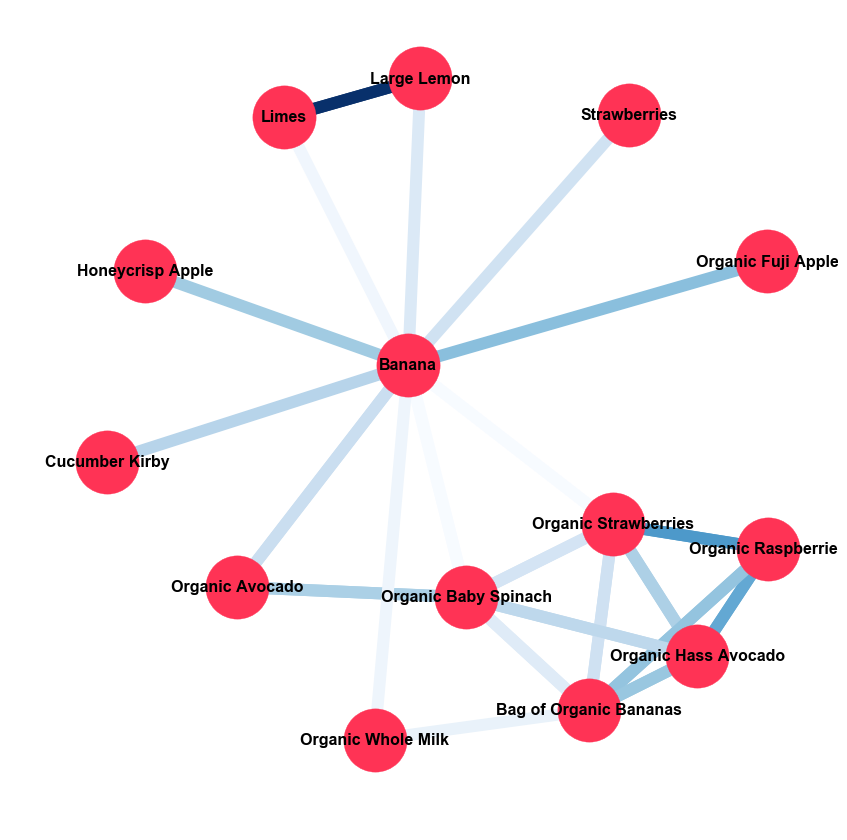

In [250]:
my_dpi=96
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi,facecolor="lightslategray")

plt.facecolor="Black"
edges = G.edges()
colors = [G[u][v]['Lift'] for u,v in edges]
nx.draw(G,with_labels=True,node_color="#ff3355",node_size=2250,edge_color=colors, arrows=False,font_color="Black",font_weight="bold",font_size=12,style="solid",width=9,edge_cmap=plt.cm.Blues)



plt.savefig("nx.png",format="png" )
plt.show()